## Import necessary libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import xgboost as xgb
#IMPORTING XGBOOST WRAPPER OF SKLEARN
from xgboost.sklearn import XGBClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from scipy.sparse import *
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from wordcloud import WordCloud
from sklearn.external import joblib

## Load preprocessed data 

In [13]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp
y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

avg_sent_vectors=openfromfile('avg_sent_vectors')
avg_sent_vectors_test=openfromfile('avg_sent_vectors_test')

tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')
tfidf_sent_vectors_test=openfromfile('tfidf_sent_vectors_test')

## Save and Load Model:

In [46]:
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

## Standardizing data

In [14]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

### Observation:
1. In Decision Tree based algorithm we are not dealing with distance at all.
2. So, Data Standardization is not required for DecisionTree, GBDT and Random-Forest.

## Ensemble Models

### Function for hyperparameter tunning using corss validation and error plot using heatmap:

In [16]:
# find Optimal value of hyperparam by TimeSeriesSplit and 10_fold_cross _validation
# using RandomizedSearchCV and GridSearchCV.   
def Ensemble_Classifier(x_train,y_train,TBS,params,searchMethod,vect,classifier):
    if classifier=='random_forest':
        #INITIALIZE RANDOM-FOREST CLASSIFIER
        clf=RandomForestClassifier(class_weight='balanced',\
                                   criterion='gini',\
                                   oob_score=True)
    elif classifier =='gbdt':
        #INITIALIZE GBDT CLASSIFIER
        clf=xgb.XGBClassifier(nthread=8,\
                              learning_rate=.1,\
                              gamma=0,\
                              subsample=.8,\
                              colsample_bytree=.8,\
                              booster='gbtree',\
                              objective='binary:logistic')
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           cv=TBS,\
                           n_jobs=-1,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=-1,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params['max_depth']),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    #PLOT THE PERFORMANCE OF MODEL ON CROSSVALIDATION DATA FOR EACH HYPERPARAM VALUE
    auc_results=[]
    auc_results.append(model.cv_results_['mean_test_score'])
    auc_results.append(model.cv_results_['mean_train_score'])
    data=['CV','Train']; i=0;
    plt.figure(1,figsize= (17,6))
    for auc in auc_results:
        auc=np.array(auc).reshape(len(params['max_depth']),len(params['n_estimators'])) 
        cv_auc_df=pd.DataFrame(auc, np.array(params['max_depth']),np.array(params['n_estimators']))
        cv_auc_df=cv_auc_df.round(4)
        plt.subplot(int('12'+str(i+1)))
        plt.title('Hyperparam Tunning %s-Data (%s)' %(data[i],vect))
        sns.set(font_scale=1.4)#for label size
        ax=sns.heatmap(cv_auc_df, annot=True,annot_kws={"size": 12}, fmt='g',) 
        ax.set(xlabel='No. of Estimators', ylabel='Depth-Values')
        i+=1
    plt.show()
    return model

### Function which calculate performance on test data with optimal hyperparam : 

In [36]:
def test_performance(x_train,y_train,x_test,y_test,optimal,vect,summarize,classifier):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL HYPERPARAM'''
    if classifier=='random_forest': 
        #INITIALIZE RANDOM FOREST WITH OPTIMAL VALUE OF HYPERPARAMS
        clf=RandomForestClassifier(n_estimators=optimal['n_estimators'],\
                                   max_depth=optimal['max_depth'],\
                                   class_weight='balanced',\
                                   criterion='gini',\
                                   oob_score=True,\
                                   n_jobs=-1)
    elif classifier=='gbdt':
        #INITIALIZE GBDT WITH OPTIMAL VALUE OF HYPERPARAMS 
        clf=xgb.XGBClassifier(n_estimators=optimal['n_estimators'],\
                              max_depth=optimal['max_depth'],\
                              nthread=8,\
                              learning_rate=.1,\
                              gamma=0,\
                              subsample=.8,\
                              colsample_bytree=.8,\
                              booster='gbtree',\
                              objective='binary:logistic',\
                              n_jobs=-1)
    clf.fit(x_train,y_train)
    train_prob=clf.predict_proba(x_train)[:,1]
    test_prob=clf.predict_proba(x_test)[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, test_prob,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, train_prob,pos_label=1)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    y_pred=clf.predict(x_test)
    f1=f1_score(y_test,y_pred,average='weighted')
    
    #ADD RESULTS TO PRETTY TABLE
    summarize.add_row([vect, optimal['max_depth'],optimal['n_estimators'], '%.3f' %auc_score_test,'%.3f' %f1])
    
    plt.figure(1,figsize=(14,5))
    plt.subplot(121)
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    #PLOT CONFUSION MATRIX USING HEATMAP
    plt.subplot(122)
    plt.title('Confusion-Matrix(Test Data)')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ['Negative','Positive'],['Negative','Positive'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()
    return clf

### Function which print top important features (feature importance):

In [9]:
def feature_importance(vectorizer,clf,n):
    '''FUNCTION FOR FEATURE IMPORTANCE AND PLOT CORRESPONDING IMPORTANT FEATURES IN WORDCLOUD AND BARCHART'''
    #CALCULATE FEATURE IMPORTANCES FROM ENSEMBLE MODEL
    importances = clf.feature_importances_
    
    # SORT FEATURE IMPORTANCES IN DECENDING ORDER
    indices = np.argsort(importances)[::-1][:n]

    # Rearrange feature names so they match the sorted feature importances
    names = vectorizer.get_feature_names()
    names=np.array(names)
    
    #wordcloud plot
    wordcloud = WordCloud(max_font_size=50, max_words=100,collocations=False).\
    generate(str(names[indices]))
    plt.figure(1,figsize=(14,13))
    plt.title("WordCloud(Important Feature)")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
    #bar chart 
    plt.figure(2,figsize=(13,8))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    # Create plot title
    plt.title("Feature Importance")
    # Add bars
    plt.bar(range(n), importances[indices])
    # Add feature names as x-axis labels
    plt.xticks(range(n), names[indices], rotation=70)
    # Show plot
    plt.show()

### Initialization of common objects required for all vectorization:

In [10]:
#ENSEMBLE MODEL TO USE
classifier=['random_forest','gbdt']
#VECTORIZER
vect=['BoW','TF-IDF','AVG-W2V','TFIDF-W2V']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING
searchMethod='grid'
#RANGE OF VALUES FOR HYPERPARAM
estimators=[16,32,64,128,256,512]
depth=[9,16,18,20]
params={'max_depth':depth,'n_estimators':estimators}
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Optimal-Depth', 'Optimal #Estimators', 'Test(AUC)','Test(f1-score)']

### Observation:
1. In case of Random Forest, base learners are high variance(low train error) models.
2. Here the base learners are Decision Tree and Decision Tree is having high variance when the tree is of significant depth(high depth).
3. So here we are taking high depth values in our hyperparam as well.

### [1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

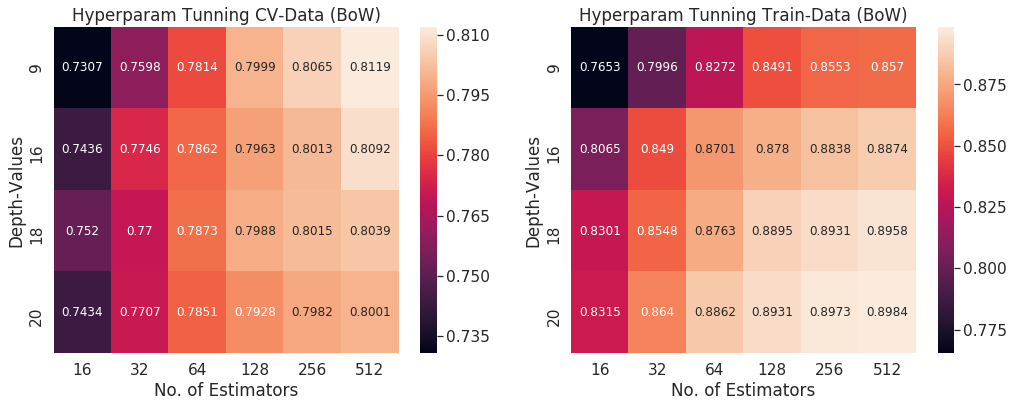

CPU times: user 50.1 s, sys: 588 ms, total: 50.7 s
Wall time: 6min 35s
{'max_depth': 9, 'n_estimators': 512}


In [17]:
#TRAIN AND TEST DATA
train=X_train_bigram;test=X_test_bigram;
#defaulat search tech='GridSearch'
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[0],classifier[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print(model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_rf')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=9
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .8119 and 
        b. auc for train data is .857 
        

#### [1.1.2] Performance on test data with optimal value of hyperparam:

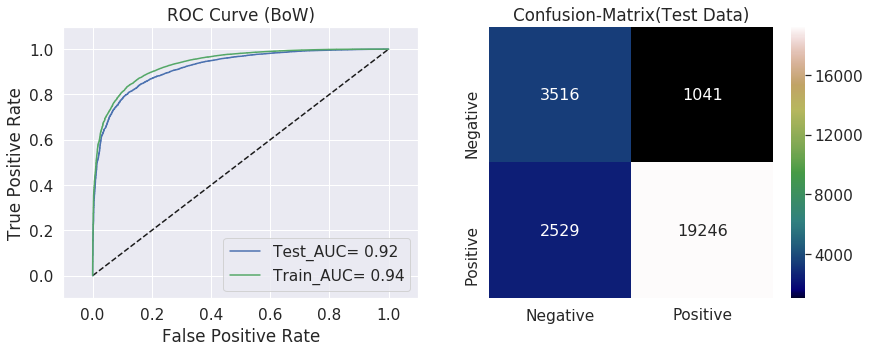

In [18]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[0],summarize,classifier[0])


#### [1.1.3] Top 20 important features:

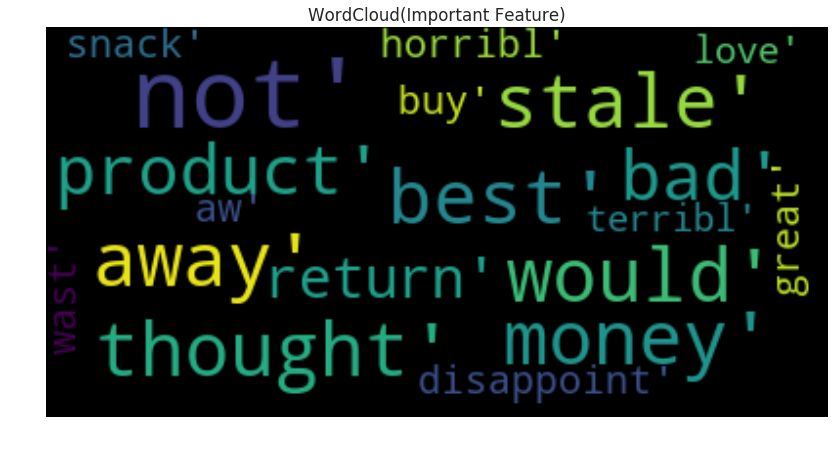

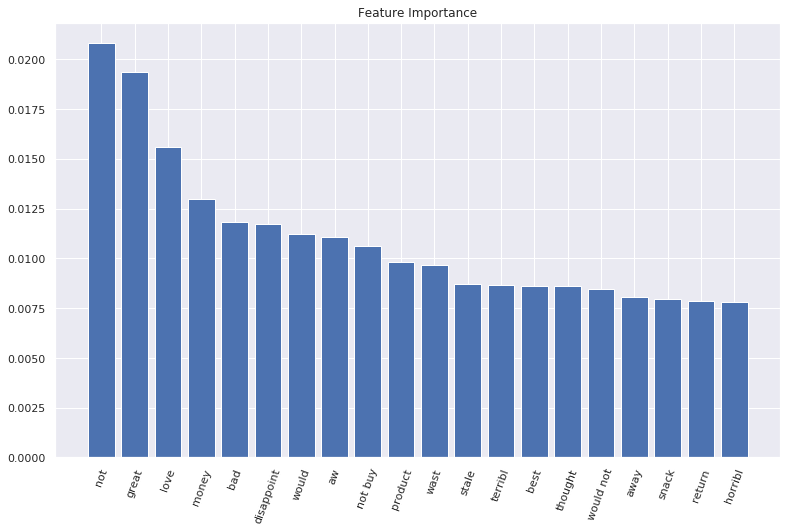

In [19]:
no_of_imp_features=20
feature_importance(count_vect,clf,no_of_imp_features)

### Observation:
1. Random Forest is good at overall interpretation.
2. feature_importances_ provides the overall important feature.
2. We can't get class based feature importance in Random Forest.

### [2.1] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

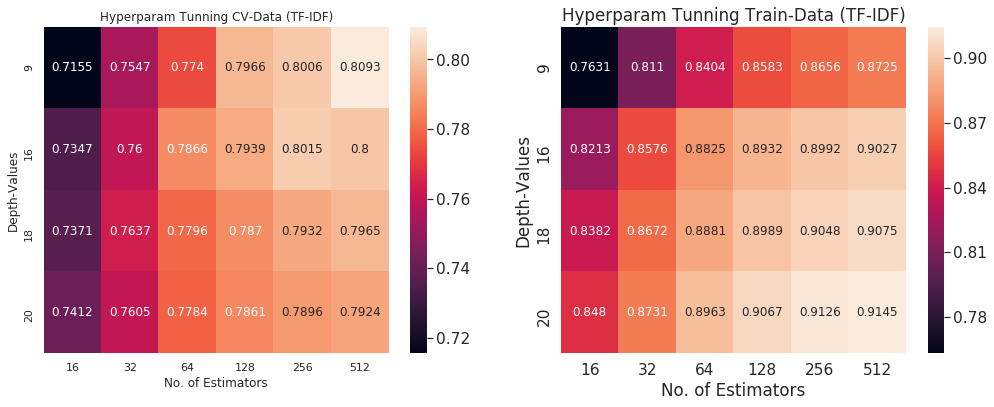

CPU times: user 52.5 s, sys: 688 ms, total: 53.2 s
Wall time: 6min 47s
Optimal value of hyperparam:  {'max_depth': 9, 'n_estimators': 512}


In [20]:
#TRAIN AND TEST DATA
#train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
train=X_train_tfidf;test=X_test_tfidf;
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[1],classifier[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_rf')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=9
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .8093 and 
        b. auc for train data is .8725 
        

#### [2.1.2] Performance on test data with optimal value of hyperparam:

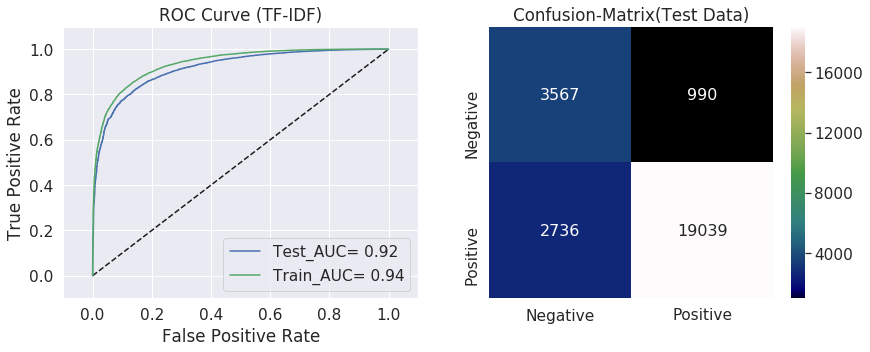

In [21]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[1],summarize,classifier[0])

#### [2.1.3] Top 20 important features:

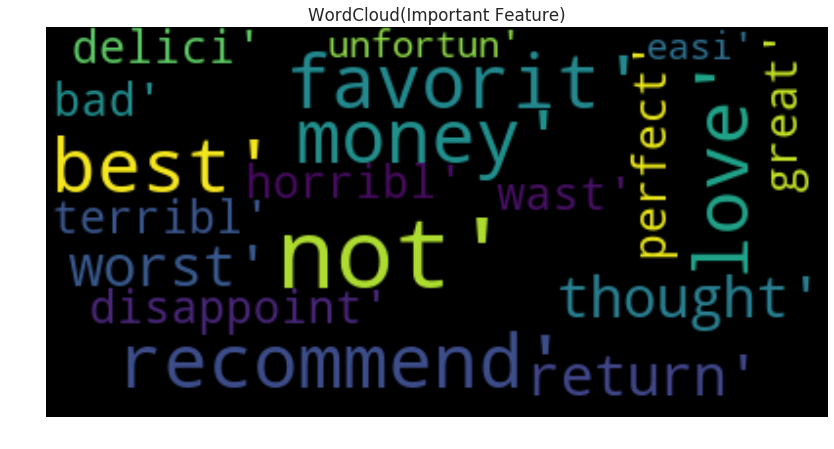

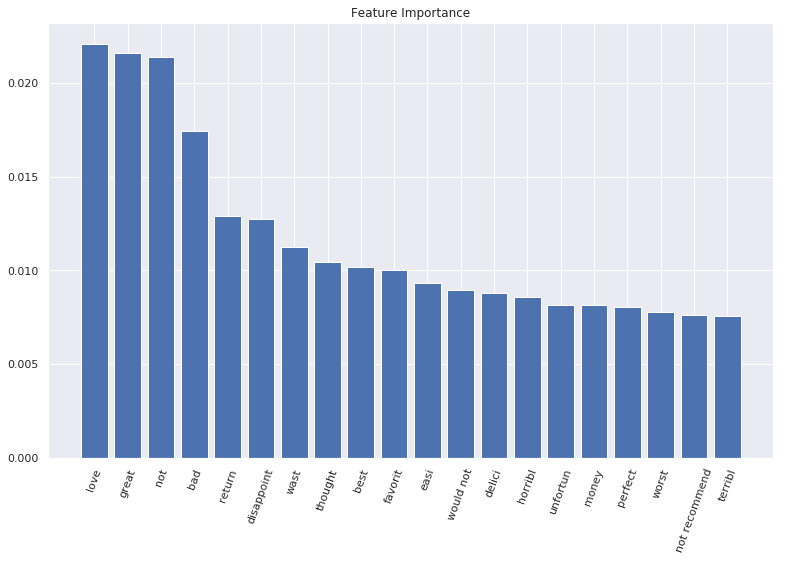

In [22]:
no_of_imp_features=20
feature_importance(tf_idf_vect,clf,no_of_imp_features)

### Observation:
1. Random Forest is good at overall interpretation.
2. feature_importances_ provides the overall important feature.
2. We can't get class based feature importance in Random Forest.

### [3.1] Applying Random Forests on AVG-W2V,<font color='red'> SET 3</font>

#### [3.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

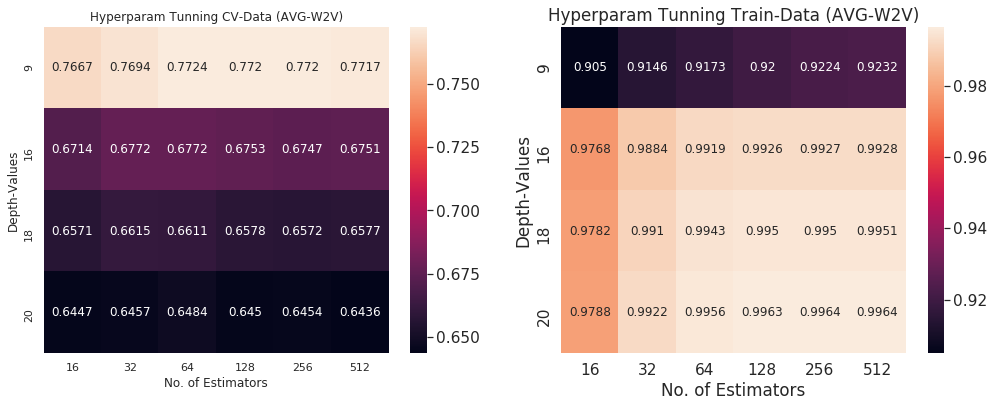

CPU times: user 6min 15s, sys: 30.8 s, total: 6min 45s
Wall time: 22min 13s
Optimal value of hyperparam:  {'max_depth': 9, 'n_estimators': 64}


In [23]:
#TRAIN AND TEST DATA
#train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
train=avg_sent_vectors;test=avg_sent_vectors_test;
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[2],classifier[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_rf')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=9
        b. n_estimators=64
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7224 and 
        b. auc for train data is .9173 
        

#### [3.1.2] Performance on test data with optimal value of hyperparam:

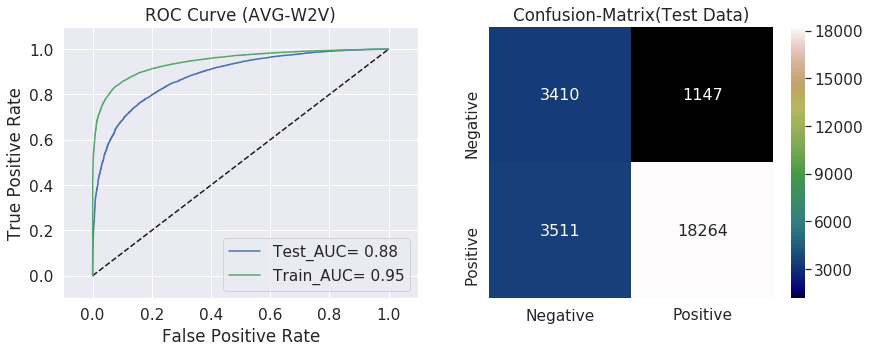

In [24]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[2],summarize,classifier[0])

### [4.1] Applying Random Forests on TFIDF-W2V,<font color='red'> SET 4</font>

#### [4.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

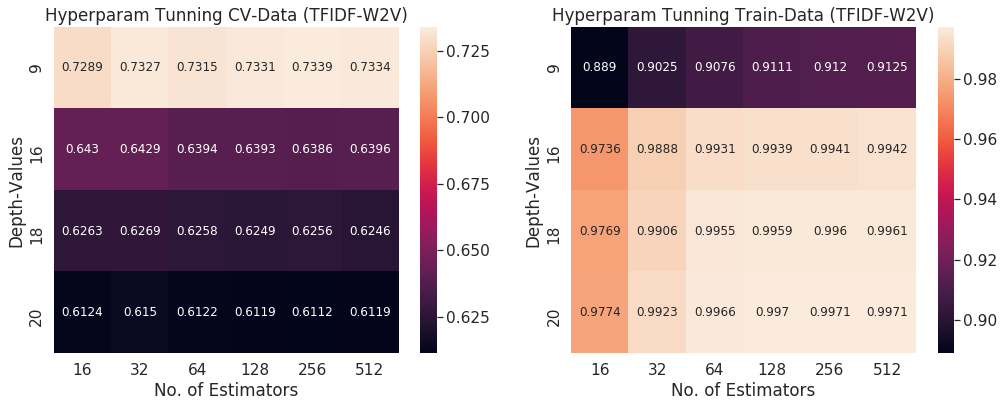

CPU times: user 7min 52s, sys: 30.8 s, total: 8min 23s
Wall time: 24min 18s
Optimal value of hyperparam:  {'max_depth': 9, 'n_estimators': 256}


In [25]:
#TRAIN AND TEST DATA
#train, test=std_data(train=avg_sent_vectors,test=avg_sent_vectors_test,mean=True)
train=tfidf_sent_vectors;test=tfidf_sent_vectors_test;
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[3],classifier[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidfw2v_rf')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=9
        b. n_estimators=256
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7339 and 
        b. auc for train data is .912 
        

#### [4.1.2] Performance on test data with optimal value of hyperparam:

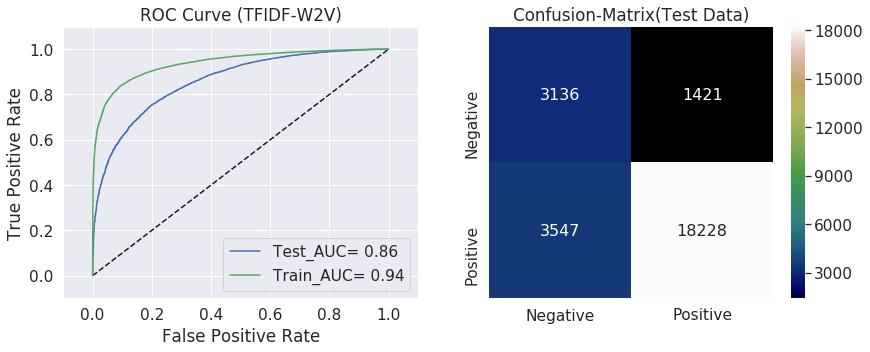

In [26]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[3],summarize,classifier[0])

## Conclusion:

In [27]:
#summarize.del_row(2)
print(summarize)

+------------+---------------+---------------------+-----------+----------------+
| Vectorizer | Optimal-Depth | Optimal #Estimators | Test(AUC) | Test(f1-score) |
+------------+---------------+---------------------+-----------+----------------+
|    BoW     |       9       |         512         |   0.921   |     0.872      |
|   TF-IDF   |       9       |         512         |   0.917   |     0.867      |
|  AVG-W2V   |       9       |          64         |   0.884   |     0.836      |
| TFIDF-W2V  |       9       |         256         |   0.860   |     0.824      |
+------------+---------------+---------------------+-----------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
        a. Bag of word vectorizer
        b. f1-score=.872 and auc=.921

## ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## [2] GBDT(Gradient Booted Decision Tree)

In [28]:
#INITIALIZE PRETTY TABLE OBJECT
summarize_gbdt = PrettyTable()
summarize_gbdt.field_names = ['Vectorizer', 'Optimal-Depth', 'Optimal #Estimators', 'Test(AUC)','Test(f1-score)']
#IN GBDT THE BASE LEARNERS ARE HIGH BIAS MODELS SO WE TAKE LOWER VALUES OF DEPTH IN HYPERPARAM
params['max_depth']=[3,5,7,9,12]

### Observation:
1. In case of GBDT, base learners are high bias(high train error) models.
2. Here the base learners are Decision Tree and Decision Tree is highly biased when the tree is shallow(low depth).
3. So here we are taking low depth values in our hyperparam as well.

### [1.1] Applying GBDT on BOW,<font color='red'> SET 1</font>

#### [1.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

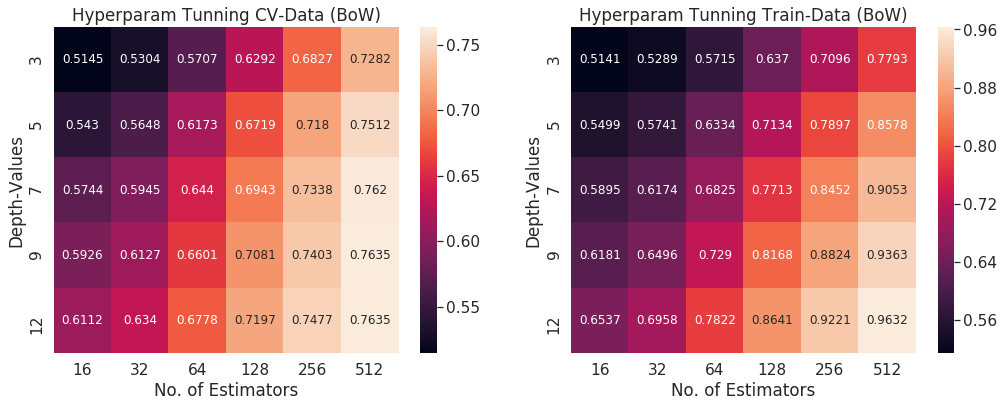

CPU times: user 7min 48s, sys: 1.79 s, total: 7min 50s
Wall time: 1h 5min 1s
Optimal value of hyperparam:  {'max_depth': 9, 'n_estimators': 512}


In [29]:
#TRAIN AND TEST DATA
#train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
train=X_train_bigram;test=X_test_bigram;
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[0],classifier[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_gbdt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=9
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7282 and 
        b. auc for train data is .7793 
        

#### [1.1.2] Performance on test data with optimal value of hyperparam:

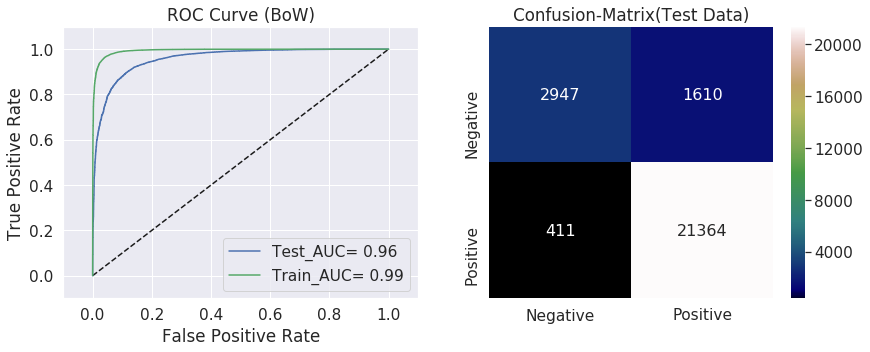

In [30]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[0],summarize_gbdt,classifier[1])

#### [1.1.3] Top 20 important features:

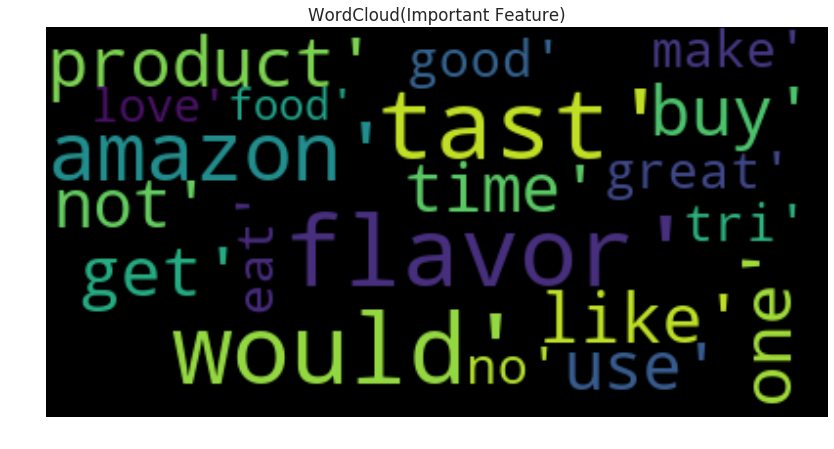

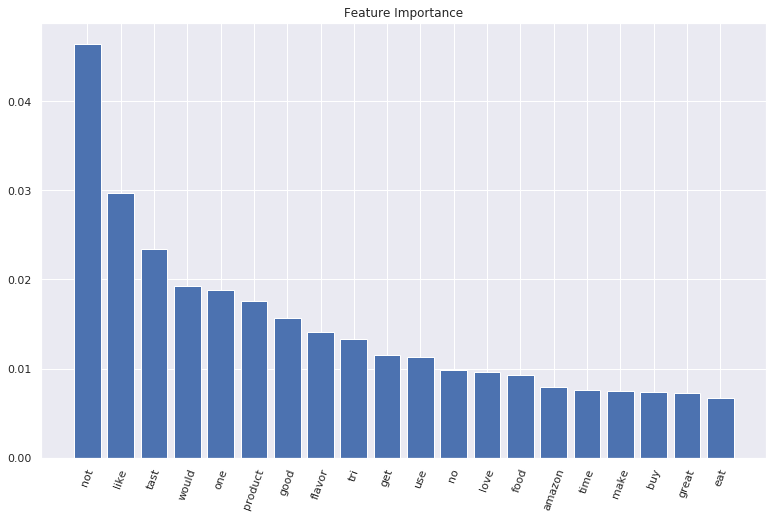

In [31]:
no_of_imp_features=20
feature_importance(count_vect,clf,no_of_imp_features)

### Observation:
1. GBDT is good at overall interpretation.
2. feature_importances_ provides the overall important feature.
2. We can't get class based feature importance in GBDT.

### [2.1] Applying GBDT on TFIDF,<font color='red'> SET 2</font>

#### [2.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

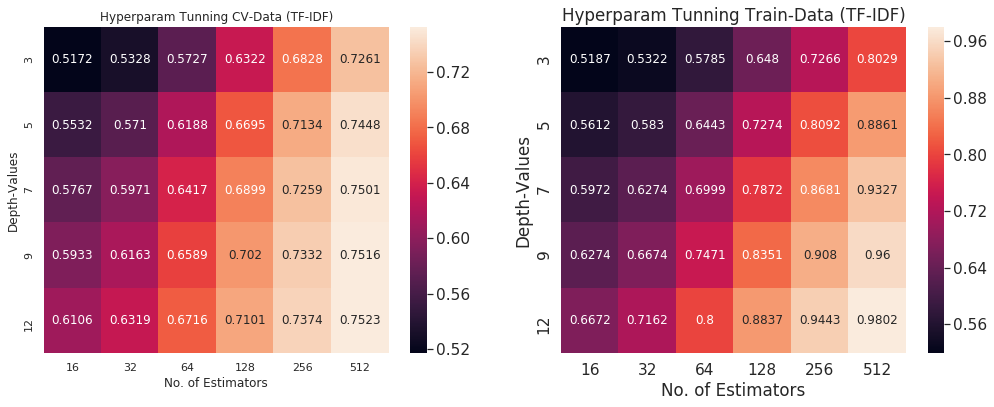

CPU times: user 14min 46s, sys: 2.39 s, total: 14min 48s
Wall time: 1h 22min 36s
Optimal value of hyperparam:  {'max_depth': 12, 'n_estimators': 512}


In [32]:
# TRAIN AND TEST DATA
#train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
train=X_train_tfidf;test=X_test_tfidf;
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[1],classifier[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_gbdt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=12
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7523 and 
        b. auc for train data is .9802 
        

#### [2.1.2] Performance on test data with optimal value of hyperparam:

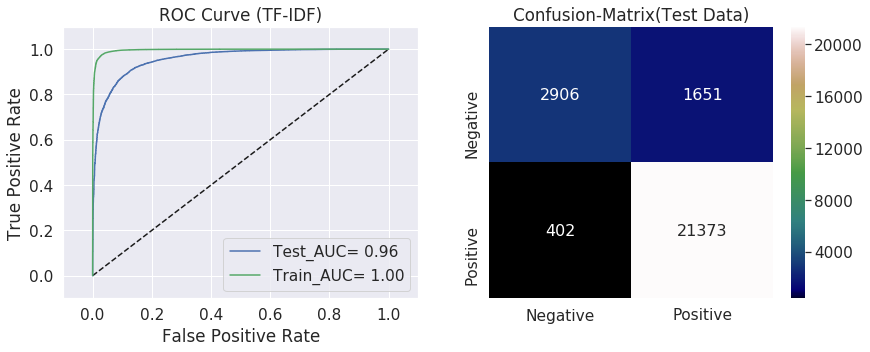

In [35]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[1],summarize_gbdt,classifier[1])

#### [2.1.3] Top 20 important features:

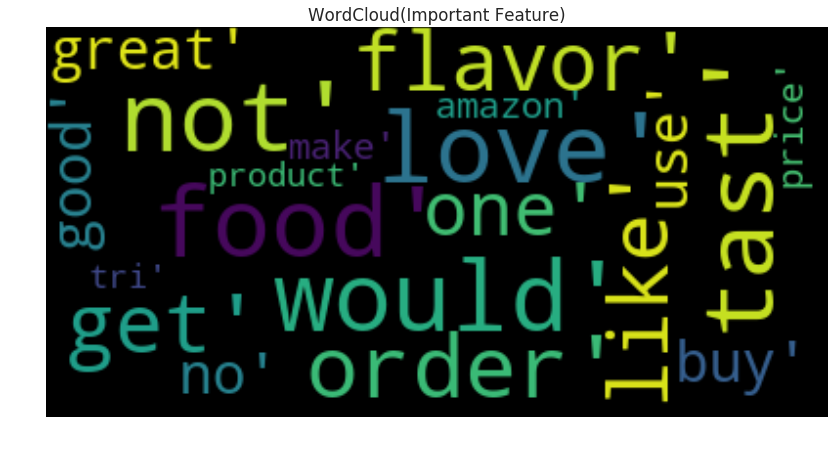

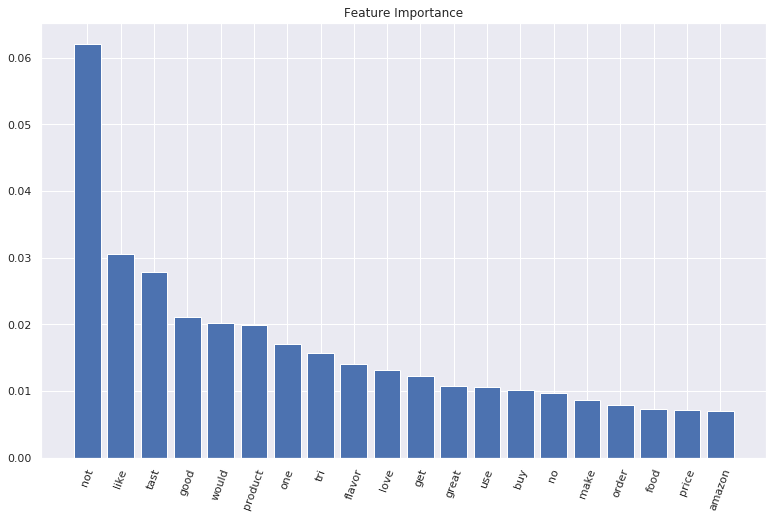

In [25]:
no_of_imp_features=20
feature_importance(tf_idf_vect,clf,no_of_imp_features)

### Observation:
1. GBDT is good at overall interpretation.
2. feature_importances_ provides the overall important feature.
2. We can't get class based feature importance in GBDT.

### [3.1]  Applying GBDT on AVG W2V,<font color='red'> SET 3</font>

#### [3.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

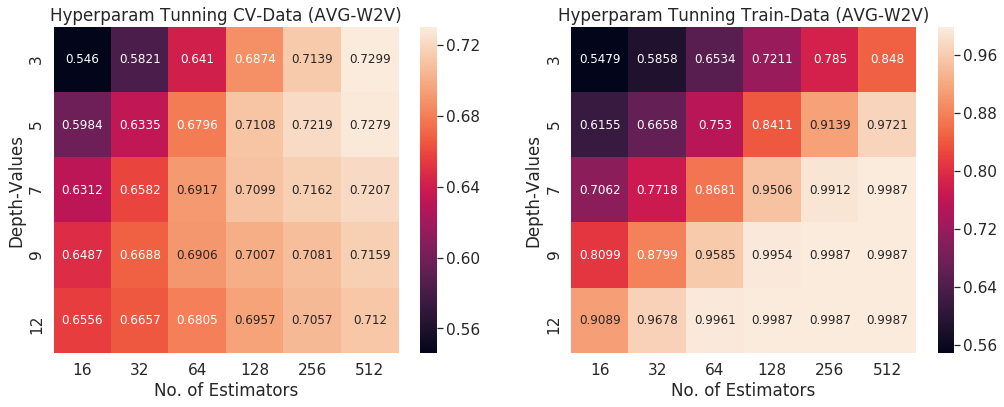

CPU times: user 3min 29s, sys: 1.92 s, total: 3min 31s
Wall time: 1h 3min 5s
Optimal value of hyperparam:  {'max_depth': 3, 'n_estimators': 512}


In [37]:
#TRAIN AND TEST DATA(convert the avgw2v to array)
train=np.array(avg_sent_vectors);test=np.array(avg_sent_vectors_test);
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[2],classifier[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_avgw2v_gbdt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=3
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .7299 and 
        b. auc for train data is .848 
        

#### [3.1.2] Performance on test data with optimal value of hyperparam:

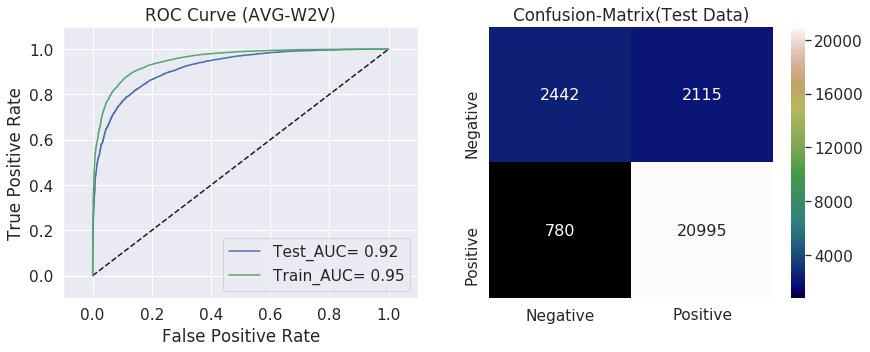

In [38]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[2],summarize_gbdt,classifier[1])

### [4.1]  Applying GBDT on TFIDF W2V,<font color='red'> SET 4</font>

#### [4.1.1] Hyperparam tunning and plot Heatmap for hyperparam:

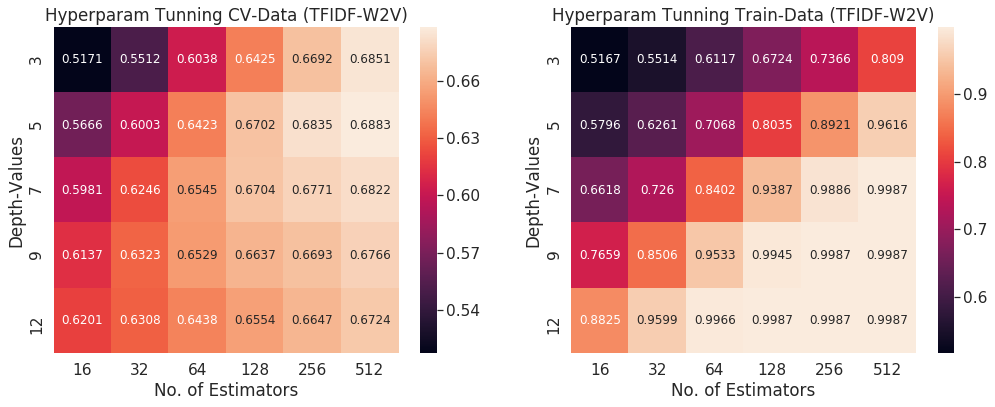

CPU times: user 5min 36s, sys: 1.66 s, total: 5min 38s
Wall time: 1h 4min 39s
Optimal value of hyperparam:  {'max_depth': 5, 'n_estimators': 512}


In [42]:
#TRAIN AND TEST DATA(convert tfidfw2v to array)
train=np.array(tfidf_sent_vectors);test=np.array(tfidf_sent_vectors_test);
#HYPERPARAM TUNNING
%time model=Ensemble_Classifier(train,y_train,TBS,params,searchMethod,vect[3],classifier[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of hyperparam: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidfw2v_gbdt')

### Observation:
1. From the above heatmaps we pick optimal value of hyperparam such that our model is not overfit and underfit.
2. We pick optimal value of hyperparams:
        a. max_depth=5
        b. n_estimators=512
3. for those optimal hyperparam, model performance:
        a. auc for crossvalidation data is .6883 and 
        b. auc for train data is .9616 
        

#### [4.1.2] Performance on test data with optimal value of hyperparam:

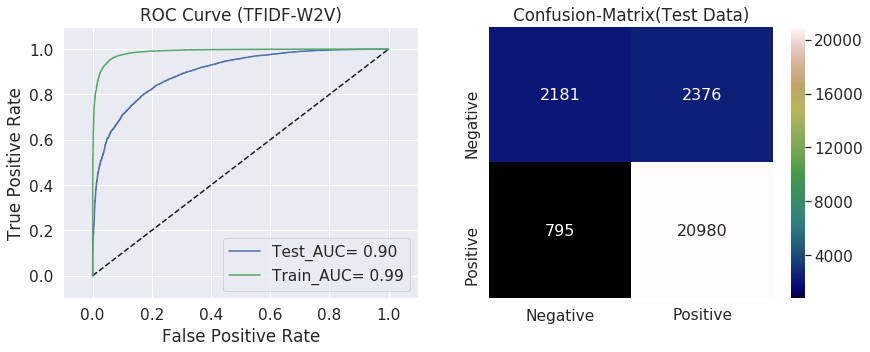

In [43]:
clf=test_performance(train,y_train,test,y_test,model.best_params_,vect[3],summarize_gbdt,classifier[1])

## Conclusion:

In [50]:
print("Summarry of GBDT model with optimal Hyperparam and Scores:" )
print(summarize_gbdt)

Summarry of GBDT model with optimal Hyperparam and Scores:
+------------+---------------+---------------------+-----------+----------------+
| Vectorizer | Optimal-Depth | Optimal #Estimators | Test(AUC) | Test(f1-score) |
+------------+---------------+---------------------+-----------+----------------+
|    BoW     |       9       |         512         |   0.958   |     0.918      |
|   TF-IDF   |       12      |         512         |   0.957   |     0.916      |
|  AVG-W2V   |       3       |         512         |   0.919   |     0.882      |
| TFIDF-W2V  |       5       |         512         |   0.899   |     0.869      |
+------------+---------------+---------------------+-----------+----------------+


### 1. from the above table we can observe that the optimal performance is give by:
        a. Bag of word vectorizer
        b. f1-score=.918 and auc=.958